# Find Richness By Camera Trap Sites

In [17]:
import pandas as pd 
import numpy as np 
import warnings 
from tabulate import tabulate
from itertools import combinations

import matplotlib.pyplot as plt

import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [18]:
warnings.filterwarnings('ignore')

In [19]:
data_dir = r'/Users/neelima/Documents/ML_Projects/data'
out_dir = r'/Users/neelima/Documents/ML_Projects/output'

In [20]:
cleaned_df = pd.read_csv(data_dir + r'/Data_Clustered_Cleaned_50km_WithSciName.csv')
cleaned_df.shape

(772478, 30)

In [21]:
cleaned_df.columns

Index(['Year', 'Project', 'Camera_Trap_Array', 'Deployment_ID', 'Sequence_ID',
       'Start_Time', 'End_Time', 'Class', 'Order', 'Family', 'Genus',
       'Species', 'Common_Name', 'Age', 'Sex', 'Group_Size', 'Site_Name',
       'Start_Date', 'End_Date', 'Survey_Nights', 'Latitude', 'Longitude',
       'Habitat', 'Development_Level', 'Feature_Type', 'Cluster_Agglo',
       'Centroid_Latitude', 'Centroid_Longitude', 'City_State', 'Sci_Name'],
      dtype='object')

In [22]:
cleaned_df.head()

,Year,Project,Camera_Trap_Array,Deployment_ID,Sequence_ID,Start_Time,End_Time,Class,Order,Family,...,Latitude,Longitude,Habitat,Development_Level,Feature_Type,Cluster_Agglo,Centroid_Latitude,Centroid_Longitude,City_State,Sci_Name
0,2019,Snapshot USA 2019,Crupi,AK_Forest_Chilkat_Preserve_1,d58722s1,2019-08-31 06:50:00,2019-08-31 06:50:00,mammalia,carnivora,ursidae,...,59.42643,-136.2225,forest,wild,water source,55,59.413873,-136.116876,Haines Borough - Alaska,Ursus arctos
1,2019,Snapshot USA 2019,Crupi,AK_Forest_Chilkat_Preserve_1,d58722s2,2019-08-31 14:15:00,2019-08-31 14:17:00,mammalia,carnivora,ursidae,...,59.42643,-136.2225,forest,wild,water source,55,59.413873,-136.116876,Haines Borough - Alaska,Ursus arctos
2,2019,Snapshot USA 2019,Crupi,AK_Forest_Chilkat_Preserve_1,d58722s3,2019-08-31 18:22:00,2019-08-31 18:22:00,mammalia,carnivora,ursidae,...,59.42643,-136.2225,forest,wild,water source,55,59.413873,-136.116876,Haines Borough - Alaska,Ursus arctos
3,2019,Snapshot USA 2019,Crupi,AK_Forest_Chilkat_Preserve_1,d58722s4,2019-08-31 20:58:00,2019-08-31 20:58:00,mammalia,carnivora,ursidae,...,59.42643,-136.2225,forest,wild,water source,55,59.413873,-136.116876,Haines Borough - Alaska,Ursus arctos
4,2019,Snapshot USA 2019,Crupi,AK_Forest_Chilkat_Preserve_1,d58722s4,2019-08-31 20:58:00,2019-08-31 20:58:00,mammalia,carnivora,ursidae,...,59.42643,-136.2225,forest,wild,water source,55,59.413873,-136.116876,Haines Borough - Alaska,Ursus arctos


In [24]:
array_proximity_with_year_df = pd.read_csv(out_dir + r'/camera_array_5km_proximity_sites.csv')
array_proximity_with_year_df.shape

(591, 5)

In [25]:
array_proximity_with_year_df.columns

Index(['Camera_Trap_Array', 'Year', 'Mean_Latitude', 'Mean_Longitude',
       'Proximity_List'],
      dtype='object')

In [26]:
# Unique Camera trap array elements count 
array_proximity_with_year_df['Camera_Trap_Array'].nunique()

262

### Calculate Species Richness 

In [41]:
import ast

def calculate_species_richness_by_array(merged_df, proximity_df, start_year, end_year):
    """
    Calculates species richness for each camera trap array and year,
    based on deployment IDs grouped in proximity and filtered by year range.

    Parameters:
    - merged_df (pd.DataFrame): Camera trap observation data
    - proximity_df (pd.DataFrame): Contains 'Camera_Trap_Array', 'Year', and 'Proximity_List'
    - start_year (int): Start of the year range (inclusive)
    - end_year (int): End of the year range (inclusive)

    Returns:
    - pd.DataFrame: A summary table with species richness for each array-year combination
    """
    
    # Safely parse proximity list
    def parse_proximity_list(s):
        if isinstance(s, str):
            try:
                parsed = ast.literal_eval(s)
                return set(i.strip() for i in parsed if isinstance(i, str))
            except:
                return set()
        return set()

    proximity_df = proximity_df.copy()
    proximity_df['Proximity_List'] = proximity_df['Proximity_List'].apply(parse_proximity_list)

    # Filter by the specified year range
    proximity_df = proximity_df[
        (proximity_df['Year'] >= start_year) & (proximity_df['Year'] <= end_year)
    ]

    grouped = proximity_df.groupby('Camera_Trap_Array').agg({
        'Proximity_List': lambda lists: set().union(*lists),
        'Mean_Latitude': 'mean',
        'Mean_Longitude': 'mean',
        'Year': lambda years: sorted(set(years))
    }).reset_index()

    richness_records = []

    for _, row in grouped.iterrows():
        array_id = row['Camera_Trap_Array']
        deployment_ids = row['Proximity_List']
        mean_lat = row['Mean_Latitude']
        mean_lon = row['Mean_Longitude']
        years_used = row['Year']

        # Filter merged_df for matching deployments and year
        subset = merged_df[
            (merged_df['Deployment_ID'].isin(deployment_ids)) &
            (merged_df['Year'].between(start_year, end_year))
        ]

        unique_species = subset['Species'].nunique()

        richness_records.append({
            'Camera_Trap_Array': array_id,
            'Species_Richness': unique_species,
            'Deployments_Used': len(deployment_ids),
            'Years_Used': ', '.join(str(y) for y in years_used),
            'Mean_Latitude': round(mean_lat, 4),
            'Mean_Longitude': round(mean_lon, 4)
        })

    result_df = pd.DataFrame(richness_records)
    return result_df

In [ ]:
richness_2019 = calculate_species_richness_by_array(cleaned_df, array_proximity_with_year_df, start_year=2019, end_year=2019)

In [43]:
richness_2019

,Camera_Trap_Array,Species_Richness,Deployments_Used,Years_Used,Mean_Latitude,Mean_Longitude
0,Abilene,11,10,2019,32.2393,-99.8829
1,Angelina,11,16,2019,31.5007,-94.7791
2,Ardmore,8,16,2019,34.0068,-97.2381
3,Baggs,10,10,2019,41.2716,-107.6542
4,Bogan,11,15,2019,42.7167,-73.8575
5,BridgewaterState,17,8,2019,41.9860,-70.9585
6,Brooke,12,7,2019,40.4258,-86.9598
7,Brookings,12,10,2019,44.3308,-96.8169
8,BullShoals,8,9,2019,36.5684,-93.0691
9,Burneyville,7,11,2019,33.9288,-97.2272


In [ ]:
richness_2020 = calculate_species_richness_by_array(cleaned_df, array_proximity_with_year_df, start_year=2020, end_year=2020)
richness_2020

,Camera_Trap_Array,Species_Richness,Deployments_Used,Years_Used,Mean_Latitude,Mean_Longitude
0,Abilene,17,11,2020,32.2383,-99.8839
1,Angelina,11,15,2020,31.4999,-94.7760
2,Ardmore,14,14,2020,34.0077,-97.2387
3,Baggs,11,10,2020,41.2716,-107.6535
4,Bogan,15,14,2020,42.7169,-73.8580
5,BridgewaterState,15,8,2020,41.9860,-70.9586
6,Brooke,15,8,2020,40.4257,-86.9605
7,Brookings,12,9,2020,44.3346,-96.8083
8,BullShoals,12,9,2020,36.5688,-93.0707
9,Burneyville,10,13,2020,33.9283,-97.2274


In [ ]:
richness_2021 = calculate_species_richness_by_array(cleaned_df, array_proximity_with_year_df, start_year=2021, end_year=2021)
richness_2021

,Camera_Trap_Array,Species_Richness,Deployments_Used,Years_Used,Mean_Latitude,Mean_Longitude
0,Abilene,12,12,2021,32.2374,-99.8833
1,Angelina,9,16,2021,31.5005,-94.7783
2,Ardmore,9,16,2021,34.0065,-97.2385
3,Baggs,12,8,2021,41.2713,-107.6537
4,Bogan,12,15,2021,42.7167,-73.8577
5,BridgewaterState,17,10,2021,41.9861,-70.9583
6,Brooke,14,10,2021,40.4252,-86.9616
7,Brookings,12,10,2021,44.3302,-96.8152
8,BullShoals,13,12,2021,36.5689,-93.0696
9,Burneyville,10,13,2021,33.9283,-97.2274


In [ ]:
richness_2022 = calculate_species_richness_by_array(cleaned_df, array_proximity_with_year_df, start_year=2022, end_year=2022)
richness_2022

,Camera_Trap_Array,Species_Richness,Deployments_Used,Years_Used,Mean_Latitude,Mean_Longitude
0,Abilene,17,11,2022,32.2364,-99.8847
1,Angelina,8,18,2022,31.5156,-94.7727
2,Ardmore,14,20,2022,34.0061,-97.2361
3,Baggs,13,15,2022,41.2757,-107.6521
4,Bogan,13,15,2022,42.7164,-73.8575
5,BridgewaterState,14,10,2022,41.9857,-70.9584
6,Brooke,13,10,2022,40.4252,-86.9616
7,Brookings,13,15,2022,44.3338,-96.8078
8,BullShoals,13,11,2022,36.5686,-93.0686
9,Burneyville,14,17,2022,33.9281,-97.2251


In [ ]:
richness_2023 = calculate_species_richness_by_array(cleaned_df, array_proximity_with_year_df, start_year=2023, end_year=2023)
richness_2023

,Camera_Trap_Array,Species_Richness,Deployments_Used,Years_Used,Mean_Latitude,Mean_Longitude
0,Abilene,13,12,2023,32.2379,-99.8841
1,Angelina,10,18,2023,31.5007,-94.7790
2,Ardmore,14,21,2023,34.0051,-97.2358
3,Baggs,10,15,2023,41.2757,-107.6521
4,Bogan,11,14,2023,42.7165,-73.8578
5,BridgewaterState,16,9,2023,41.9860,-70.9584
6,Brooke,10,8,2023,40.4259,-86.9617
7,Brookings,12,13,2023,44.3343,-96.8108
8,BullShoals,16,10,2023,36.5691,-93.0709
9,Burneyville,12,17,2023,33.9281,-97.2251


In [ ]:
richness_3_years = calculate_species_richness_by_array(cleaned_df, array_proximity_with_year_df, start_year=2019, end_year=2021)
richness_3_years

,Camera_Trap_Array,Species_Richness,Deployments_Used,Years_Used,Mean_Latitude,Mean_Longitude
0,Abilene,17,33,"2019, 2020, 2021",32.2383,-99.8834
1,Angelina,14,47,"2019, 2020, 2021",31.5004,-94.7778
2,Ardmore,14,41,"2019, 2020, 2021",34.0070,-97.2384
3,Baggs,17,28,"2019, 2020, 2021",41.2715,-107.6538
4,Bogan,18,44,"2019, 2020, 2021",42.7168,-73.8577
5,BridgewaterState,20,26,"2019, 2020, 2021",41.9860,-70.9585
6,Brooke,18,24,"2019, 2020, 2021",40.4256,-86.9606
7,Brookings,13,29,"2019, 2020, 2021",44.3319,-96.8135
8,BullShoals,13,30,"2019, 2020, 2021",36.5687,-93.0698
9,Burneyville,11,34,"2019, 2020, 2021",33.9285,-97.2273


In [ ]:
richness_5_years = calculate_species_richness_by_array(cleaned_df, array_proximity_with_year_df, start_year=2019, end_year=2023)
richness_5_years

,Camera_Trap_Array,Species_Richness,Deployments_Used,Years_Used,Mean_Latitude,Mean_Longitude
0,Abilene,21,54,"2019, 2020, 2021, 2022, 2023",32.2379,-99.8838
1,Angelina,14,83,"2019, 2020, 2021, 2022, 2023",31.5035,-94.7770
2,Ardmore,17,82,"2019, 2020, 2021, 2022, 2023",34.0064,-97.2374
3,Baggs,19,58,"2019, 2020, 2021, 2022, 2023",41.2732,-107.6531
4,Bogan,20,73,"2019, 2020, 2021, 2022, 2023",42.7166,-73.8577
5,BridgewaterState,20,45,"2019, 2020, 2021, 2022, 2023",41.9860,-70.9584
6,Brooke,19,42,"2019, 2020, 2021, 2022, 2023",40.4256,-86.9610
7,Brookings,16,57,"2019, 2020, 2021, 2022, 2023",44.3327,-96.8118
8,BullShoals,16,51,"2019, 2020, 2021, 2022, 2023",36.5688,-93.0698
9,Burneyville,14,68,"2019, 2020, 2021, 2022, 2023",33.9283,-97.2264


In [96]:
output_path = out_dir + r'/richness_5_years.csv'
richness_5_years.to_csv(output_path, index=False)

In [88]:
def plot_species_richness_map(richness_df, year=None, start_year=None, end_year=None):
    """
    Plot species richness on a geographic map for a single year or a range of years.

    Parameters:
    - richness_df (pd.DataFrame): Must contain:
        ['Mean_Latitude', 'Mean_Longitude', 'Species_Richness', 'Year']
    - year (int, optional): Single year to plot
    - start_year (int, optional): Start of year range
    - end_year (int, optional): End of year range
    """

    # Handle filtering and title
    if year is not None:
        df_plot = richness_df
        title = f"Species Richness per Camera Trap Array ({year})"
    elif start_year is not None and end_year is not None:
        df_plot = richness_df
        title = f"Species Richness per Camera Trap Array ({start_year}–{end_year})"
    else:
        raise ValueError("You must provide either 'year' or both 'start_year' and 'end_year'.")

    # Plot
    fig = plt.figure(figsize=(12, 8))
    ax = plt.axes(projection=ccrs.PlateCarree())

    ax.set_title(title, fontsize=16)
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.STATES, linestyle=':')
    ax.gridlines(draw_labels=True, linewidth=0.3)

    ax.set_xlabel("Longitude", fontsize=12)
    ax.set_ylabel("Latitude", fontsize=12)

    sc = ax.scatter(
        df_plot['Mean_Longitude'],
        df_plot['Mean_Latitude'],
        c=df_plot['Species_Richness'],
        s=100,
        cmap='viridis',
        edgecolors='black',
        transform=ccrs.PlateCarree()
    )

    cbar_ax = fig.add_axes([1.0, 0.25, 0.02, 0.5])  # adjust height = 0.5, bottom = 0.25
    cbar = plt.colorbar(sc, cax=cbar_ax)
    cbar.set_label('Species Richness')

    plt.tight_layout()
    plt.show()

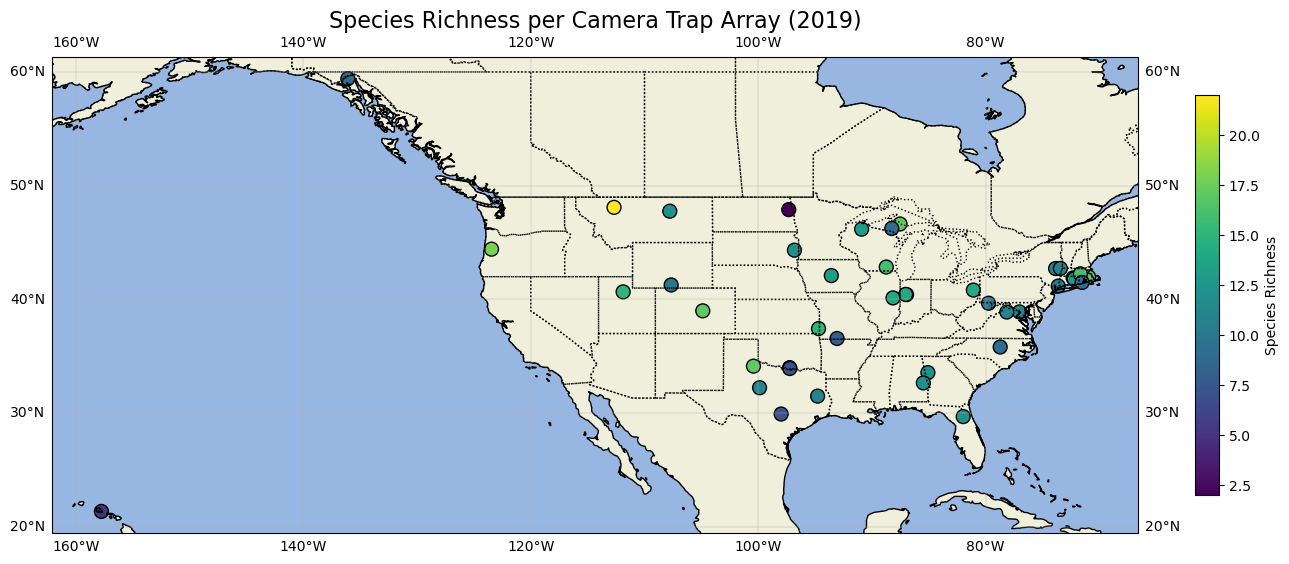

In [89]:
plot_species_richness_map(richness_2019, year=2019)

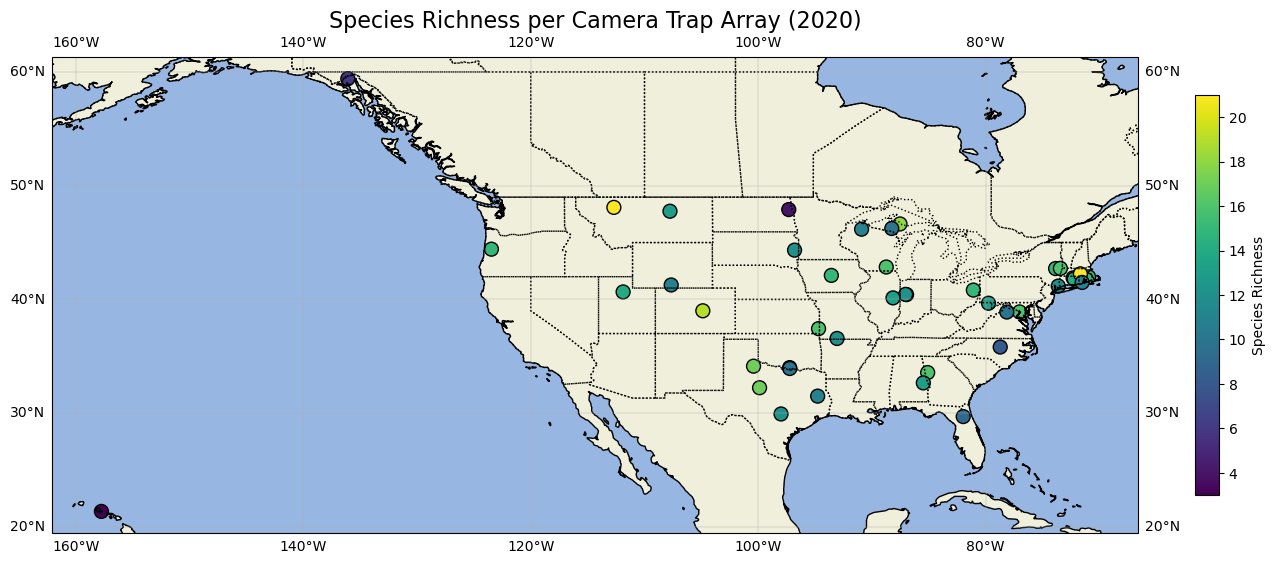

In [90]:
plot_species_richness_map(richness_2020, year=2020)

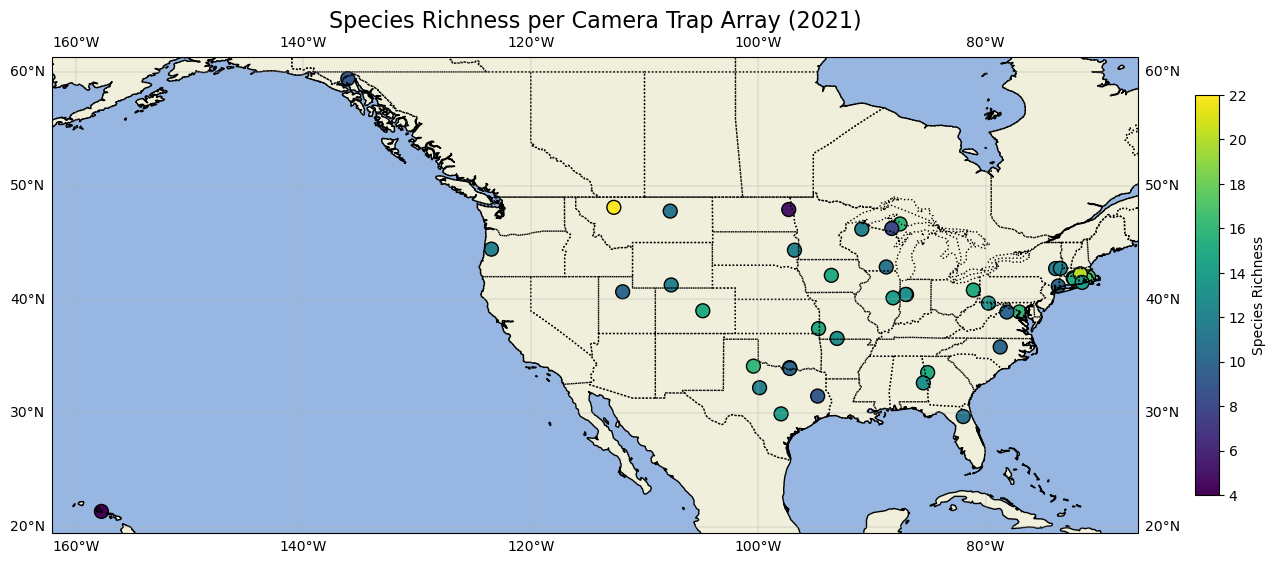

In [91]:
plot_species_richness_map(richness_2021, year=2021)

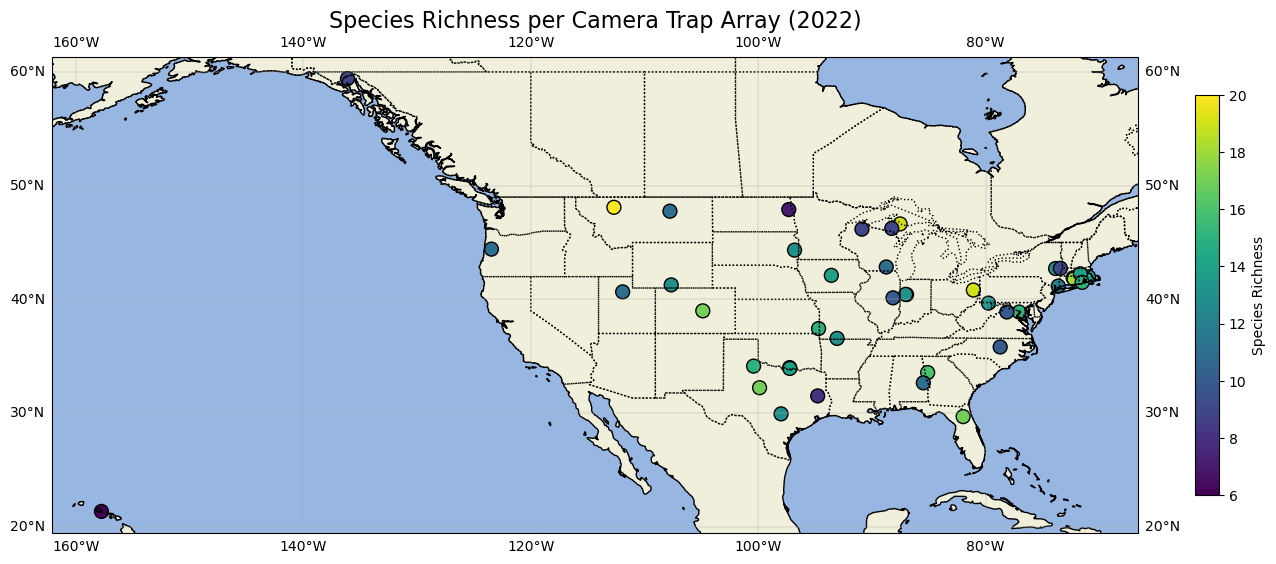

In [92]:
plot_species_richness_map(richness_2022, year=2022)

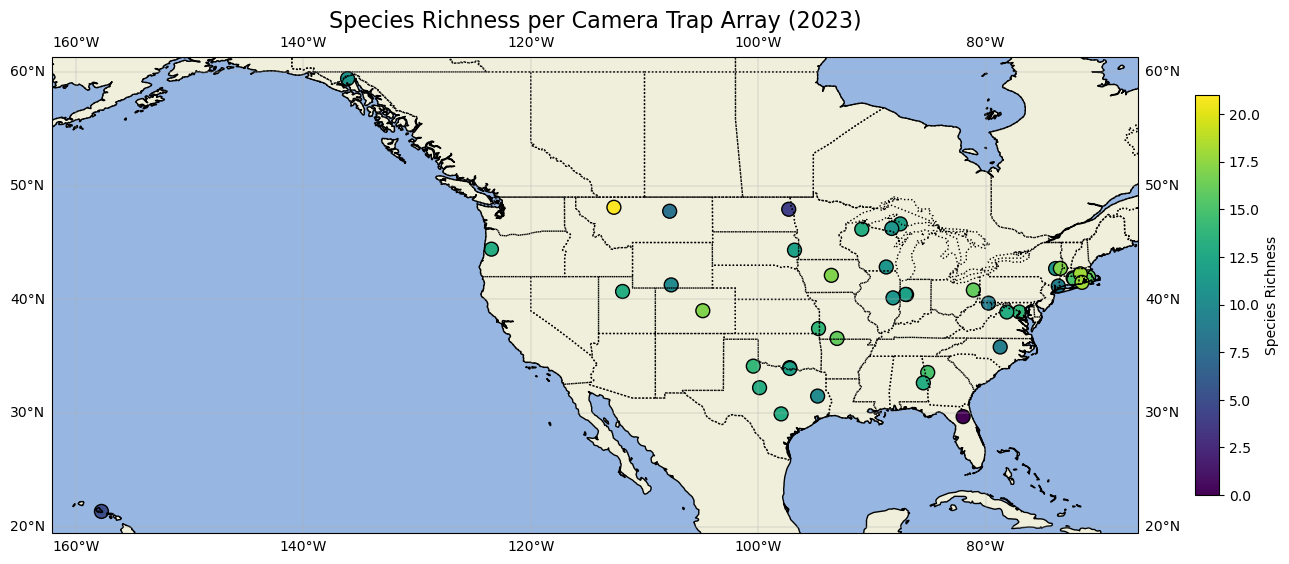

In [93]:
plot_species_richness_map(richness_2023, year=2023)

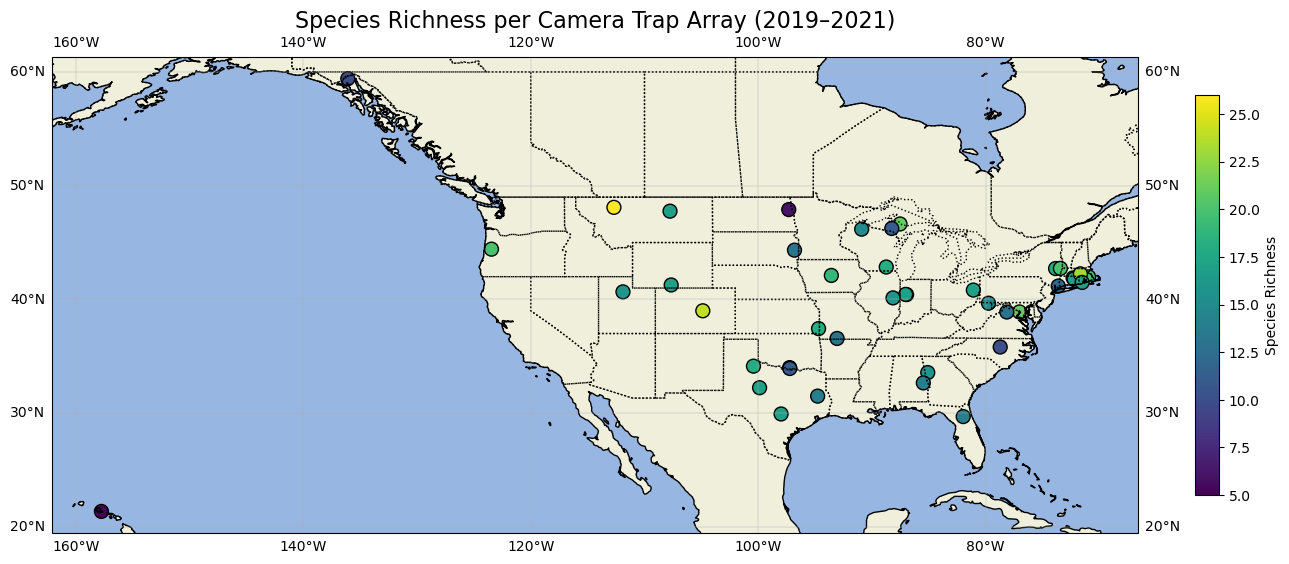

In [94]:
plot_species_richness_map(richness_3_years, year=None, start_year=2019, end_year=2021)

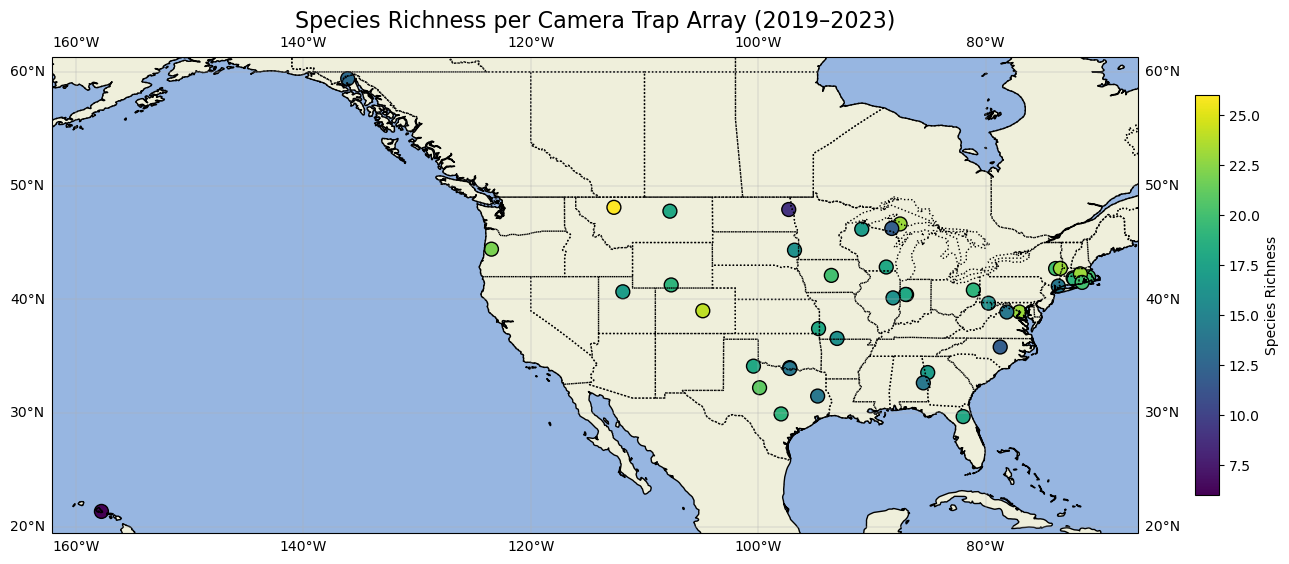

In [95]:
plot_species_richness_map(richness_5_years, year=None, start_year=2019, end_year=2023)